## Install

In [28]:
!pip install python-doctr
!pip install "python-doctr[tf]"
!pip install "python-doctr[torch]"

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from PIL import Image, ImageDraw
from doctr.io import DocumentFile
from doctr.io.elements import Block, Document, KIEDocument, KIEPage, Line, Page, Prediction, Word
from doctr.models import ocr_predictor
from google.colab.patches import cv2_imshow

from __future__ import print_function
import torch
import cv2
from google.colab import files

In [30]:
from doctr.utils.geometry import resolve_enclosing_bbox
from doctr.models import builder
from doctr.models import detection_predictor

## Functions

In [31]:
def reorder_coordinates(coordinates):

    ordered_coordinates = []
    for polygon_coords in coordinates:
        most_left_coords = polygon_coords[np.argsort(polygon_coords[:, 0])][:2]
        sorted_most_left_coords = most_left_coords[np.argsort(most_left_coords[:, 1])]
        most_left_top = sorted_most_left_coords[0]
        idx = np.where((polygon_coords == most_left_top).all(axis=1))[0][0]

        reordered_coords = np.roll(polygon_coords, -idx, axis=0)
        ordered_coordinates.append(reordered_coords)
    return ordered_coordinates


def sort_by_y_of_first_coord(polygons):
    def get_y_of_first_coord(polygon):

        return min(point[1] for point in polygon)
    sorted_polygons = sorted(polygons, key=get_y_of_first_coord)
    return sorted_polygons


In [32]:
def get_xy_maxmin(box):

  tl, tr, br, bl = box[0],box[1],box[2],box[3]
  x_min, x_max = min(tl[0],tr[0],br[0],bl[0]), max(tl[0],tr[0],br[0],bl[0])
  y_min, y_max = max(tl[1],tr[1],br[1],bl[1]), min(tl[1],tr[1],br[1],bl[1])
  return x_min, x_max, y_min, y_max


def find_overlaped_y(box_index, boxes):

    overlapping_boxes = []
    box = boxes[box_index]
    tl, tr, br, bl = box[0],box[1],box[2],box[3]
    target_x_min, target_x_max, target_y_min, target_y_max = get_xy_maxmin(box)

    for idx, b in enumerate(boxes):
        if idx != box_index:
            x_min, x_max, y_min, y_max = get_xy_maxmin(b)
            if check_overlapping_y(y_min, y_max,target_y_min ,target_y_max):
                overlapping_boxes.append(idx)
    return overlapping_boxes


def check_overlapping_y(y1_min, y1_max, y2_min, y2_max):

  if (y1_min >= y2_max and y1_min <= y2_min) or (y1_max >= y2_max and y1_max <= y2_min) or (y1_max <= y2_max and y1_min >= y2_min): return True
  else: return False


def check_x_overlap(box1, box2, thr=0.08):

  x1_min, x1_max, _, __ = get_xy_maxmin(box1)
  x2_min, x2_max, _, __ = get_xy_maxmin(box2)
  if max(x1_min, x2_min) <= min(x1_max, x2_max):
        overlap_length = min(x1_max, x2_max) - max(x1_min, x2_min)
  else: overlap_length = 0
  overlap_coof = overlap_length / (x1_max - x1_min)
  if overlap_coof > thr: return False
  else: return True


def choose_lr_boxes(box_index, overlaped_boxes_idx, boxes):

  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  lb, rb, lb_x_max, rb_x_min, lb_idx, rb_idx = [None] * 6
  tl1, tr1,br1, bl1  = main_box[0], main_box[1],main_box[2], main_box[3]
  word_height = bl1[1] - tl1[1]

  for idx in overlaped_boxes_idx:

            box = boxes[idx]
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tr, br  = box[1],box[2]
            dist_l = distance_between_points(tr, tl1) + distance_between_points(br, bl1)
            tl, tr, br, bl  = box[0],box[1],box[2],box[3]
            dist_r = distance_between_points(tl, tr1) + distance_between_points(bl, br1)

            if (x_max < x1_max) and (word_height*3>dist_l) and check_overlapping_y(br[1], tr[1], bl1[1] ,tl1[1]):

                if lb is None or dist_l < lb_dist:
                    lb = box
                    lb_dist = dist_l
                    lb_idx = idx

            elif (x_min > x1_min) and (word_height*3>dist_r)  and check_overlapping_y(bl[1], tl[1], br1[1] ,tr1[1]):

                if rb is None or dist_r < rb_dist:
                    rb = box
                    rb_dist = dist_r
                    rb_idx = idx
  return lb, lb_idx, rb, rb_idx


def choose_l_box(box_index, overlaped_boxes_idx, boxes):

  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  lb = None
  lb_x_max = None
  lb_idx = None
  tl1, bl1  = main_box[0],main_box[3]
  word_height = bl1[1] - tl1[1]
  for idx in overlaped_boxes_idx:

            box = boxes[idx]
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tr, br  = box[1],box[2]
            dist = distance_between_points(tr, tl1) + distance_between_points(br, bl1)

            if (x_max < x1_max) and (word_height*3>dist) and check_overlapping_y(br[1], tr[1], bl1[1] ,tl1[1]):
                if lb is None or dist < lb_dist:
                    lb = box
                    lb_dist = dist
                    lb_idx = idx
  return lb, lb_idx


def choose_r_box(box_index, overlaped_boxes_idx, boxes):

  main_box = boxes[box_index]
  x1_min, x1_max, _, __ = get_xy_maxmin(main_box)
  rb = None
  rb_x_min = None
  rb_idx = None
  tr1, br1  = main_box[1],main_box[2]
  word_height = br1[1] - tr1[1]

  for idx in overlaped_boxes_idx:

            box = boxes[idx]
            x_min, x_max, _, __ = get_xy_maxmin(box)
            tl, bl  = box[0],box[3]
            dist = distance_between_points(tl, tr1) + distance_between_points(bl, br1)
            if( x_min > x1_min) and (word_height*3>dist) and check_overlapping_y(bl[1], tl[1], br1[1] ,tr1[1]):
                if rb is None or dist < rb_dist:
                    rb = box
                    rb_dist = dist
                    rb_idx = idx
  return rb, rb_idx


def delete_elements_by_indexes(lst, indxs):
    indxs.sort(reverse=True)
    for index in indxs:
        del lst[index]


def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance


In [33]:
def draw_image_lines(lines, dr):

  for line in lines:
    first_word = line[0]
    dr.line((first_word[0][0], first_word[0][1], first_word[3][0], first_word[3][1]), fill='red', width=2)
    tr_point = first_word[1]
    br_point = first_word[2]
    last_word = line[-1]
    dr.line((last_word[1][0], last_word[1][1], last_word[2][0], last_word[2][1]), fill='red', width=2)
    for points in line:
          dr.line((points[0][0], points[0][1], points[1][0], points[1][1]), fill='red', width=2)
          dr.line((points[2][0], points[2][1], points[3][0], points[3][1]), fill='red', width=2)
          dr.line((points[0][0], points[0][1], tr_point[0], tr_point[1]), fill='red', width=2)
          dr.line((points[3][0], points[3][1], br_point[0], br_point[1]), fill='red', width=2)
          tr_point = points[1]
          br_point = points[2]


In [34]:
def group_words_into_lines(polygons):

  j = -1
  lines = []
  line_indexes = []

  while polygons:

    j-=1
    top_box = polygons[0]
    tb_overl_idx = find_overlaped_y(0, polygons)
    first_l, idx_l, first_r, idx_r = choose_lr_boxes(0, tb_overl_idx, polygons)
    line = [top_box]
    line_indexes = [0]

    while first_l is not None:
      line.insert(0, first_l)
      line_indexes.append(idx_l)
      l_overl_idx = find_overlaped_y(idx_l, polygons)
      first_l, idx_l = choose_l_box(idx_l, l_overl_idx, polygons)

    while first_r is not None:
      line.append(first_r)
      line_indexes.append(idx_r)
      r_overl_idx = find_overlaped_y(idx_r, polygons)
      first_r, idx_r = choose_r_box(idx_r, r_overl_idx, polygons)
    lines.append(line)
    delete_elements_by_indexes(polygons, line_indexes)
  return lines


In [35]:
def get_average_line_height(line):

  sum_height = 0
  for word in line:
    sum_height += abs(word[0][1] - word[3][1])
  line_height = sum_height/len(line)

  return line_height


def append_to_block(line, text_blocks):

  first_word = line[0]
  line_height = get_average_line_height(line)

  for block in text_blocks:

      block_line = block[0]
      aver_h = get_average_line_height(block_line)
      if line_height/aver_h < 0.5 or line_height/aver_h > 1.5: continue

      first_word_in_block_line = block_line[0]
      if abs(first_word_in_block_line[0][1] - first_word[3][1]) < line_height * 0.7 and abs(first_word_in_block_line[0][0] - first_word[3][0]) < line_height * 4:

        block.insert(0, line)
        return

      block_line = block[-1]
      first_word_in_block_line = block_line[0]

      if abs(first_word_in_block_line[3][1] - first_word[0][1]) < line_height * 0.7 and abs(first_word_in_block_line[3][0] - first_word[0][0]) < line_height * 4:

        block.append(line)
        return

  block = [line]
  text_blocks.append(block)


In [36]:
import random

def get_random_color():

    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)

    return red, green, blue


def draw_image_lines(lines, dr, color='red'):

  for line in lines:
    first_word = line[0]
    dr.line((first_word[0][0], first_word[0][1], first_word[3][0], first_word[3][1]), fill=color, width=2)
    tr_point = first_word[1]
    br_point = first_word[2]
    last_word = line[-1]
    dr.line((last_word[1][0], last_word[1][1], last_word[2][0], last_word[2][1]), fill=color, width=2)
    for points in line:
          dr.line((points[0][0], points[0][1], points[1][0], points[1][1]), fill=color, width=2)
          dr.line((points[2][0], points[2][1], points[3][0], points[3][1]), fill=color, width=2)
          dr.line((points[0][0], points[0][1], tr_point[0], tr_point[1]), fill=color, width=2)
          dr.line((points[3][0], points[3][1], br_point[0], br_point[1]), fill=color, width=2)
          tr_point = points[1]
          br_point = points[2]


## Model

In [37]:
# НА ПОВЕРНУТИХ КРАТИНКИ
#model = detection_predictor('linknet_resnet18_rotation', pretrained=True, assume_straight_pages=False, preserve_aspect_ratio=True)
# НА РІВНИХ КАРТИНКАХ
#model = detection_predictor('db_resnet50', pretrained=True)
#model = detection_predictor('db_resnet50', pretrained=True, assume_straight_pages=False)
model = detection_predictor('linknet_resnet18', pretrained=True, assume_straight_pages=False)

ValueError: No such layer: resnet_block_1. Existing layers are: ['conv2d_29', 'batch_normalization_34', 'activation_31', 'max_pooling2d_1', 'resnet_block_8', 'resnet_block_9', 'resnet_block_10', 'resnet_block_11', 'resnet_block_12', 'resnet_block_13', 'resnet_block_14', 'resnet_block_15'].

## Main for one

In [38]:
uploaded_image = files.upload()
file_name = next(iter(uploaded_image))
image_path = file_name

Saving text_document.png to text_document.png


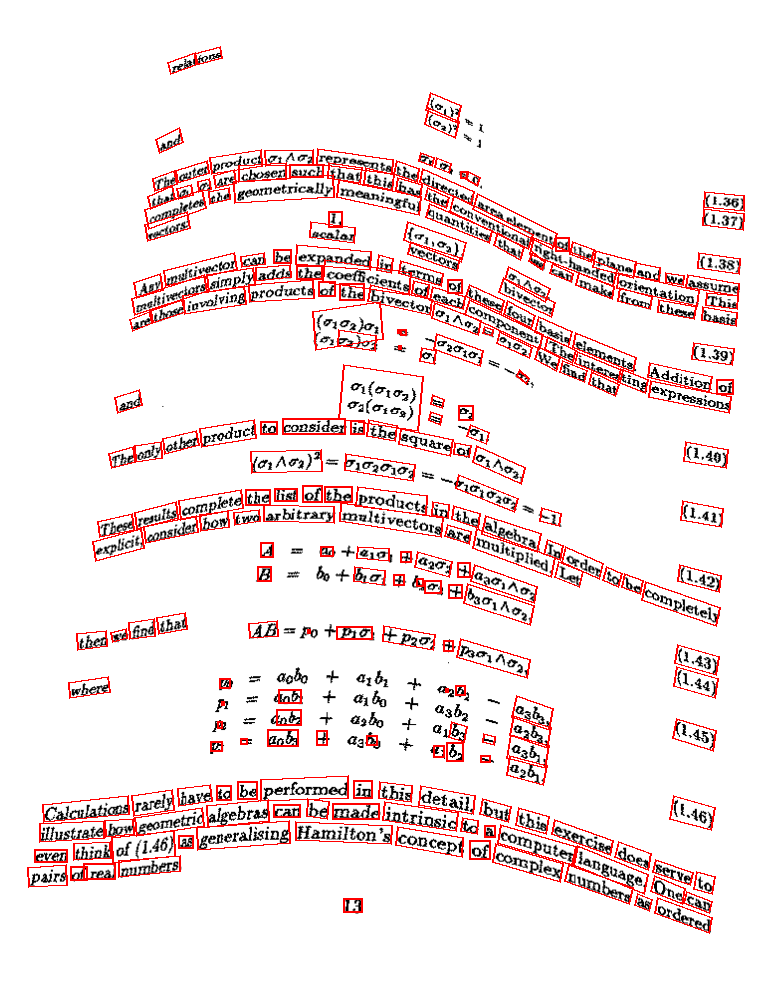

In [39]:
document = DocumentFile.from_images(image_path)
result = model(document)
words = result[0]['words']
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
width, height = image.size
words[:, :, 0] *= width
words[:, :, 1] *= height
words_dim_rotated = []

for points in words:
    draw.polygon(points, outline='red', width=2)
    words_dim_rotated.append(points)

display(image)

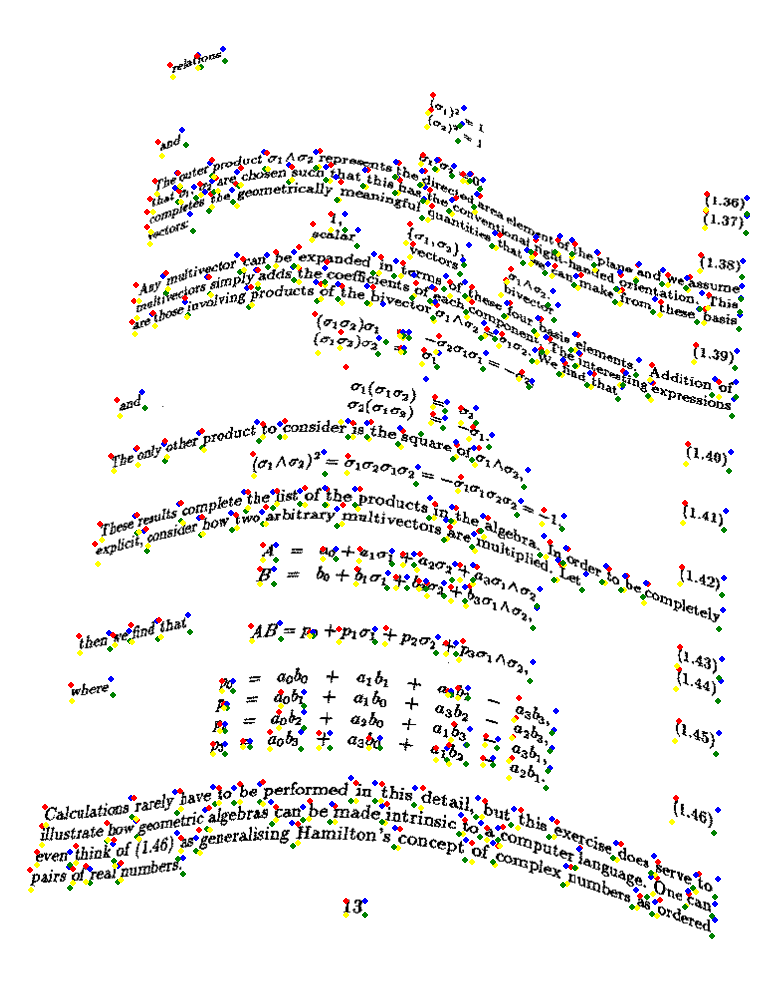

In [40]:
image_final = Image.open(image_path)
draw = ImageDraw.Draw(image_final)
width, height = image_final.size

ordered_polygons = reorder_coordinates(words_dim_rotated)

for p in ordered_polygons:
  draw.ellipse([(p[0][0],p[0][1]),(p[0][0]+5,p[0][1]+5)], fill="red")
  draw.ellipse([(p[1][0],p[1][1]),(p[1][0]+5,p[1][1]+5)], fill="blue")
  draw.ellipse([(p[2][0],p[2][1]),(p[2][0]+5,p[2][1]+5)],  fill="green")
  draw.ellipse([(p[3][0],p[3][1]),(p[3][0]+5,p[3][1]+5)],  fill="yellow")

# ДЕМОНСТРАЦІЯ ОКРЕМОГО СЛОВА ЧЕРВОНИМ ПРЯМОКУТНИКОМ
# p = ordered_polygons[-5]
# print(p)
# draw.polygon(p, outline='red', width=2)

# ЗБЕРЕГТИ
# img_name = os.path.basename(image_paths[i])
# makeDir('result_dots')
# image_final.save(f'/content/result_dots/{img_name}')

display(image_final)


In [41]:
ordered_polygons_top = sort_by_y_of_first_coord(ordered_polygons)
polygons = ordered_polygons_top.copy()
lines = group_words_into_lines(polygons)


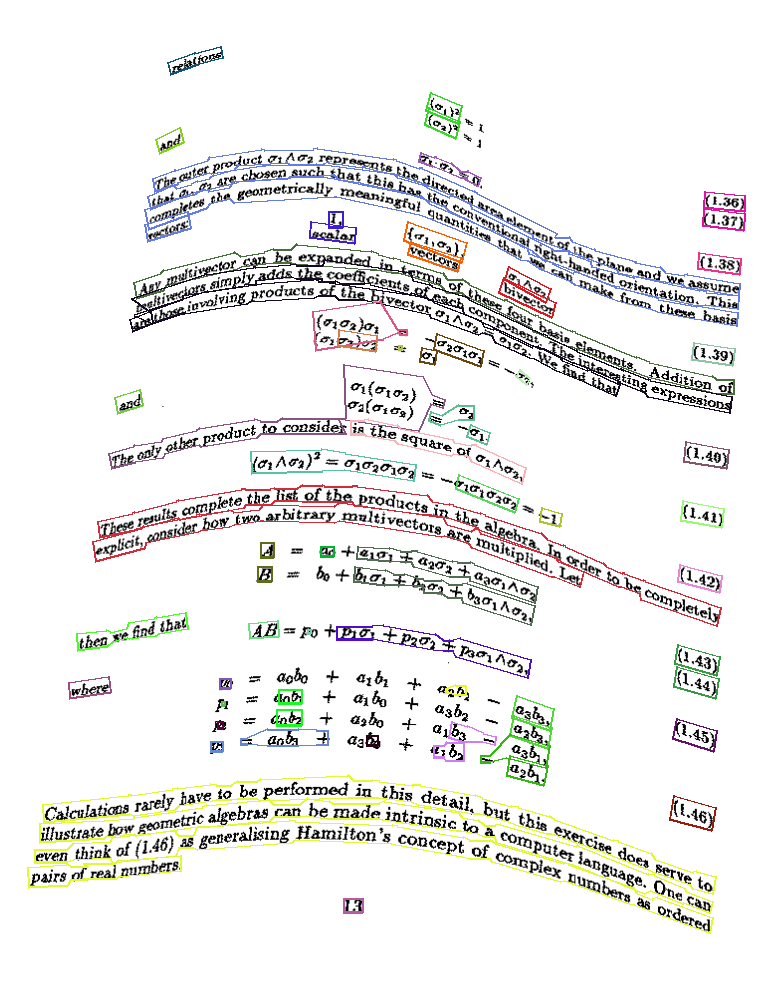

In [42]:
image_result = Image.open(image_path)
draw_result = ImageDraw.Draw(image_result)
text_blocks = []

for line in lines:
  append_to_block(line, text_blocks)

image_result = Image.open(image_path)
draw_result = ImageDraw.Draw(image_result)

for b in text_blocks:
  draw_image_lines(b, draw_result, get_random_color())

display(image_result)


In [44]:
import numpy
import math
import copy


# Define the Bresenham line algorithm
def bresenham_line(x1, y1, x2, y2):

    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while (x1, y1) != (x2, y2):
        points.append((x1, y1))
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    points.append((x1, y1))
    return points


def get_function_length(p1, p2, polynomial, step):

    distance = 0
    while p1[0] + step < p2[0]:
        next_x = p1[0] + step
        next_p = [next_x, np.polyval(polynomial, next_x)]
        distance += math.dist(p1, next_p)
        p1 = next_p

    distance += math.dist(p1, p2)
    return distance


# Check if two lines overlap in the x-axis by a given percentage
def x_overlap(line1, line2, percentage):

    critical_length = percentage * min(abs(line1[1][0] - line1[0][0]), abs(line2[1][0] - line2[0][0]))
    x_max = min(line1[1][0], line2[1][0])
    x_min = max(line1[0][0], line2[0][0])
    return x_max - x_min >= critical_length


def move_line(line_eq, points, margin, direction):

    x1, x2 = 0, 100
    y1, y2 = np.polyval(line_eq, x1), np.polyval(line_eq, x2)

    for p in points:
        m, b = line_eq
        y_p, x_p = p[1], p[0]
        x_proj = (y_p - b) / m
        if (direction == 'left' and x_proj > x_p) or (direction == 'right' and x_proj < x_p):
            diff = abs(x_proj - x_p)
            x1 += diff if direction == 'right' else -diff
            x2 += diff if direction == 'right' else -diff
            line_eq = np.polyfit([x1, x2], [y1, y2], 1)

    if direction == 'left':
        x1 -= margin
        x2 -= margin
    elif direction == 'right':
        x1 += margin
        x2 += margin

    return np.polyfit([x1, x2], [y1, y2], 1)


def find_intersection_point(polynomial1, polynomial2, closest_edge):

    poly = copy.deepcopy(polynomial1)
    poly[-1] -= polynomial2[1]
    poly[-2] -= polynomial2[0]
    roots = np.roots(poly)
    max_distance = float('inf')
    point = closest_edge

    for root in roots:
        x = np.real(root)
        y = np.polyval(polynomial2, x)
        distance = math.dist(closest_edge, (x, y))
        if distance < max_distance:
            max_distance = distance
            point = (x, y)

    return point


def get_highest_point(block):
    return min(min(line[0][0][1], line[0][1][1]) for line in block)


def get_lowest_point(block):
    return max(max(line[0][0][1], line[0][1][1]) for line in block)


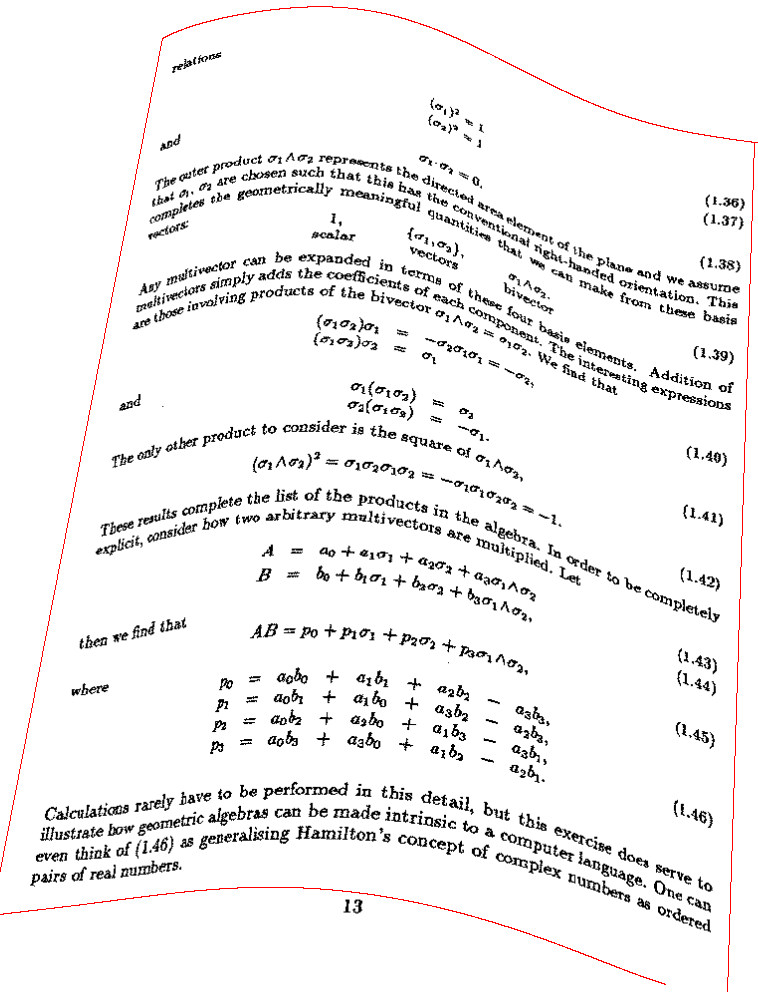

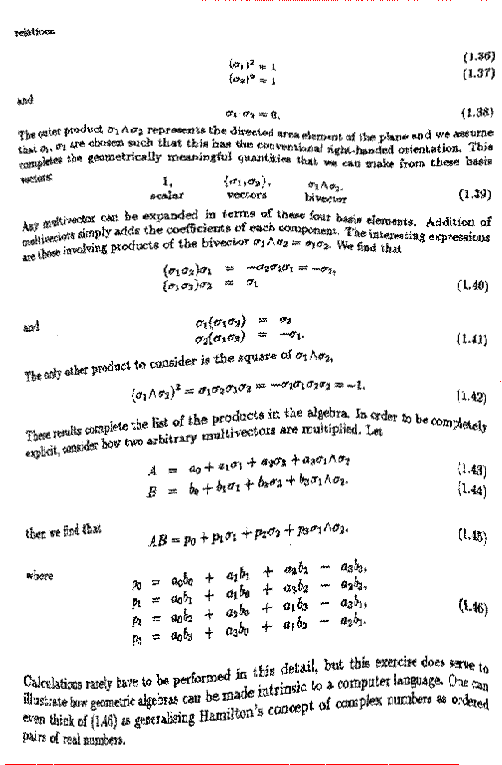

In [45]:
def find_main_line(lines):

    block_len = 0
    main_line = None
    for line in lines:
        first_word = line[0]
        last_word = line[-1]
        min_x = min(first_word[0][0], first_word[3][0])
        length = max(last_word[1][0] - min_x, last_word[2][0] - min_x)
        if length > block_len:
            block_len = length
            main_line = line
    return main_line, block_len


def extract_borders_and_lengths(lines, main_line, block_len):

    left_border, right_border, lengths, block = [], [], [], []
    x_left, y_left, x_right, y_right = [], [], [], []
    main_line_1d = [main_line[0][0], main_line[-1][1]]

    for line in lines:
        line_1d = [line[0][0], line[-1][1]]
        if x_overlap(main_line_1d, line_1d, 0.8):
            min_x = min(line[0][0][0], line[-1][3][0])
            length = max(line[0][1][0] - min_x, line[-1][2][0] - min_x)
            block.append(line)
            lengths.append(length)
            left_border.extend([line[0][0], line[0][3]])
            right_border.extend([line[-1][1], line[-1][2]])

            if length >= block_len * 0.9:
                x_left.extend([line[0][0][0], line[0][3][0]])
                y_left.extend([line[0][0][1], line[0][3][1]])
                x_right.extend([line[-1][1][0], line[-1][2][0]])
                y_right.extend([line[-1][1][1], line[-1][2][1]])

    return block, lengths, left_border, right_border, x_left, y_left, x_right, y_right


def calculate_equations(x_left, y_left, x_right, y_right, left_border, right_border):

    c1 = np.polyfit(x_left, y_left, 1)
    c2 = np.polyfit(x_right, y_right, 1)
    left_equation = move_line(c1, left_border, 10, 'left')
    right_equation = move_line(c2, right_border, 10, 'right')
    return left_equation, right_equation


def process_line_top(draw_result, block, lengths, block_len, left_equation, right_equation, image_result, margin=15):

    for i, line in enumerate(block):
        if lengths[i] >= block_len * 0.75:
            leftmost_point, rightmost_point, coefficients = get_curve_parameters(block, block_len, line, left_equation, right_equation, image_result, draw_result, margin, top=True)
            return leftmost_point, rightmost_point, coefficients
    return None, None


def process_line_bottom(draw_result, block, lengths, block_len, left_equation, right_equation, image_result, margin=30):

    for i, line in enumerate(reversed(block)):
        ri = len(block) - 1 - i
        if lengths[ri] >= block_len * 0.8:
            leftmost_point, rightmost_point, coefficients = get_curve_parameters(block, block_len, line, left_equation, right_equation, image_result, draw_result, margin, top=False)
            return leftmost_point, rightmost_point, coefficients
    return None, None


def get_curve_parameters(block, block_len, line, left_equation, right_equation, image_result, draw_result, margin, top):

    m, b = left_equation
    if top:
        y_st = get_highest_point(block) - margin
    else:
        y_st = get_lowest_point(block) + margin
    x_st = (y_st - b) / m
    start_point = [x_st, y_st]
    x_min = start_point[0]
    x_max = x_min + block_len
    x, y = [], []

    line_start = line[0][0] if top else line[0][3]
    x_dif = line_start[0] - start_point[0]
    y_dif = line_start[1] - start_point[1]

    for word in line:
        x.append(word[0][0] - x_dif)
        y.append(word[0][1] - y_dif)
        x.append(word[1][0] - x_dif)
        y.append(word[1][1] - y_dif)

    x.append(image_result.width)
    y.append(y[-1])

    coefficients = np.polyfit(x, y, 7)
    p = np.poly1d(coefficients)
    x_values = np.linspace(x_min, x_max, 10000)
    y_values = p(x_values)

    left_index = np.argmin(x_values)
    right_index = np.argmax(x_values)
    leftmost_point = (x_values[left_index], y_values[left_index])
    rightmost_point = (x_values[right_index], y_values[right_index])

    leftmost_point = find_intersection_point(coefficients, left_equation, leftmost_point)
    rightmost_point = find_intersection_point(coefficients, right_equation, rightmost_point)

    for i in range(len(x_values)):
        draw_result.point((x_values[i], y_values[i]), fill=(255, 0, 0))

    return leftmost_point, rightmost_point, coefficients


def transform_image(image_result, leftmost_point1, rightmost_point1, leftmost_point2, rightmost_point2, coefficients1, coefficients2):

    width = int(min(abs(leftmost_point1[0] - rightmost_point1[0]), abs(leftmost_point2[0] - rightmost_point2[0])))
    height = int(min(abs(leftmost_point1[1] - leftmost_point2[1]), abs(rightmost_point1[1] - rightmost_point2[1])))
    pixels = image_result.load()

    width = int(width * 0.85)
    height = int(height * 0.9)
    new_image = Image.new("RGB", (width, height), color="white")
    new_pixels = new_image.load()

    step = 3
    AB = get_function_length(leftmost_point1, rightmost_point1, coefficients1, step)
    CD = get_function_length(leftmost_point2, rightmost_point2, coefficients2, step)

    start = int(leftmost_point2[0])

    for x1 in range(int(leftmost_point1[0]), int(rightmost_point1[0])):
        y = np.polyval(coefficients1, x1)
        point1 = [x1, y]
        ab = get_function_length(leftmost_point1, point1, coefficients1, step)
        ab /= AB

        for x2 in range(start, int(rightmost_point2[0])):
            y = np.polyval(coefficients2, x2)
            point2 = [x2, y]
            cd = get_function_length(leftmost_point2, point2, coefficients2, step)
            cd /= CD
            if ab <= cd:
                start = x2
                break

        points = bresenham_line(int(point1[0]), int(point1[1]), int(point2[0]), int(point2[1]))
        eg = math.dist(point1, point2)

        for p in points:
            if p[0] > image_result.width - 1 or p[1] > image_result.height - 1:
                continue
            try:
                color = pixels[p[0], p[1]]
                x = int(width * ab)
                eo = math.dist(point1, p)
                y = int((height * eo) / eg)
                new_pixels[x, y] = color
            except Exception:
                pass

    return new_image


def main(image_path, lines):

    image_result = Image.open(image_path)
    draw_result = ImageDraw.Draw(image_result)

    main_line, block_len = find_main_line(lines)
    block, lengths, left_border, right_border, x_left, y_left, x_right, y_right = extract_borders_and_lengths(lines, main_line, block_len)
    left_equation, right_equation = calculate_equations(x_left, y_left, x_right, y_right, left_border, right_border)

    leftmost_point1, rightmost_point1, coefficients1 = process_line_top(draw_result, block, lengths, block_len, left_equation, right_equation, image_result)
    leftmost_point2, rightmost_point2, coefficients2 = process_line_bottom(draw_result, block, lengths, block_len, left_equation, right_equation, image_result)

    draw_result.line([leftmost_point1, leftmost_point2], fill=(255, 0, 0))
    draw_result.line([rightmost_point1, rightmost_point2], fill=(255, 0, 0))

    new_image = transform_image(image_result, leftmost_point1, rightmost_point1, leftmost_point2, rightmost_point2, coefficients1, coefficients2)

    new_image.save("result_image.png")
    display(image_result)
    display(new_image)


main(image_path, lines)
